In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np
import os
import logging
from scipy.integrate import odeint
from sabcom.differential_equation_model import differential_equations_model
from sabcom.estimation import constrNM, confidence_interval

# ODE model simulations

In [7]:
def demodel(**kwargs):
    input_folder_path = kwargs.get('input_folder_path')
    output_folder_path = kwargs.get('output_folder_path')

    parameters_path = os.path.join(input_folder_path, 'first_strainparameters.json')
    
    with open(parameters_path) as json_file:
        parameters = json.load(json_file)
        for param in parameters:
            logging.debug('Parameter {} is {}'.format(param, parameters[param]))

    # arguments = city
    initial_infected = parameters['total_initial_infections']
    T = len(parameters['empirical_fatalities']) # for estimation

    # Set Covid-19 Parameters:
    # basic reproduction number
    r_zero = kwargs.get('r_zero') #initial_recovered
    exposed_days = float(parameters["exposed_days"])
    asymptomatic_days = float(parameters["asymptom_days"])
    symptomatic_days = float(parameters["symptom_days"])
    critical_days = float(parameters["critical_days"])

    # compartment exit rates
    exit_rate_exposed = 1.0 / exposed_days
    exit_rate_asymptomatic = 1.0 / asymptomatic_days
    exit_rate_symptomatic = 1.0 / symptomatic_days
    exit_rate_critical = 1.0 / critical_days

    probability_symptomatic = parameters["probability_symptomatic"]
    # Probability to become critically ill if symptomatic (source: Verity et al.2020)
    probability_critical = np.array([x for x in parameters["probability_critical"].values()])
    # Probability to die if critically ill (source: Silal et al.2020)
    probability_to_die = np.array([x for x in parameters["probability_critical"].values()])

    # Total population:
    district_population = pd.read_csv(os.path.join(input_folder_path, 'f_population.csv'), index_col=0)
    district_population = district_population.values
    population = parameters["empirical_population"] #district_population.sum()  # sum over wards to obtain city population

    # Set city specific parameters
    hospital_capacity = int(round(parameters["health_system_capacity"] * population))

    # Population by age group (N_age(i) is the population of age group i)
    ward_age_distribution = pd.read_csv(os.path.join(input_folder_path, 'f_age_distribution.csv'),
                                        index_col=0)  # the datafile contains ward level fractions in each age group
    N_age = ward_age_distribution * district_population  # convert to number of people in age group per ward
    N_age = N_age.sum()  # sum over wards
    N_age = N_age.values  # store city level population sizes of each age group

    # Load raw contact matrices
    household_contacts = pd.read_csv(os.path.join(input_folder_path, 'f_household_contacts.csv'), index_col=0)
    other_contacts = pd.read_csv(os.path.join(input_folder_path, 'f_nonhousehold_contacts.csv'), index_col=0)
    contact_matrix = household_contacts + other_contacts
    contact_matrix = contact_matrix.values

    # Replicate last row and column to change the 8 category contact matrix to a 9 category matrix
    contact_matrix = np.vstack((contact_matrix, contact_matrix[7, 0:8]))
    C_last_column = contact_matrix[0:9, 7]
    C_last_column.shape = (9, 1)
    contact_matrix = np.hstack((contact_matrix, C_last_column))

    # Apply reciprocity correction (see Towers and Feng (2012))
    # C_corrected(j,k) = (C(j,k)*N(j) + C(k,j)*N(k))/(2*N(j))
    for j in range(contact_matrix.shape[0]):
        for k in range(contact_matrix.shape[0]):
            contact_matrix[j, k] = (contact_matrix[j, k] * N_age[j] + contact_matrix[k, j] * N_age[k]) / (2 * N_age[j])

    # Scale contact matrix by population size
    # - each column is normalized by the population of that age group: X(i,j)=C(i,j)/N_age(j)
    N_age_row_vector = np.array(N_age)
    N_age_row_vector.shape = (1, 9)
    contact_probability_matrix = np.divide(contact_matrix,
                                           N_age_row_vector)  # X(i,j)=C(i,j)/N_age(j) - entries now measure fraction of each age group contacted on average per day

    # Compute infection_rate from R0, exit_rate_asymptomatic, e_S and dominant eigenvalue of matrix X(i,j)*N_age(i)
    N_age_column_vector = np.array(N_age)
    N_age_column_vector.shape = (9, 1)
    eigen_values, eigen_vectors = np.linalg.eig(np.multiply(contact_probability_matrix, N_age_column_vector))
    dom_eig_val = max(eigen_values)
    
    # TODO CAN WE CHANGE R_ZERO TO ... 
    infection_rate = (((1 - probability_symptomatic) * exit_rate_asymptomatic + probability_symptomatic * exit_rate_symptomatic) * r_zero) / dom_eig_val

    # Set initial conditions
    # spread initial infections (exposed individuals) across age groups equally
    initial_exposed = (initial_infected / 9) * np.ones(9)
    # compute remaining initial populations in susceptible compartments
    initial_susceptible = N_age - initial_exposed
    # initiallise other compartments at zero
    initial_asymptomatic = np.zeros(9)
    initial_symptomatic = np.zeros(9)
    initial_critical = np.zeros(9)
    initial_recovered = np.zeros(9)
    initial_dead = np.zeros(9)

    # Solve model over time from initial conditions, using ODE solver from scipy:
    time_points = np.linspace(1, T, T)  # Grid of time points (in days)
    initial_compartments = np.concatenate((initial_susceptible, initial_exposed, initial_asymptomatic,
                                           initial_symptomatic, initial_critical, initial_recovered, initial_dead),
                                          axis=0)

    # Integrate the differential equations over the time grid, t.
    integrals = odeint(differential_equations_model, initial_compartments, time_points, args=(
        infection_rate, contact_probability_matrix, exit_rate_exposed, exit_rate_asymptomatic, exit_rate_symptomatic,
        exit_rate_critical, probability_symptomatic, probability_critical, probability_to_die, hospital_capacity))

    # integrals is T by 63, needs to be split in compartments, each disease compartments has 9 age groups
    susceptible = integrals[:, 0:9].sum(axis=1)
    exposed = integrals[:, 9:18].sum(axis=1)
    asymptomatic = integrals[:, 18:27].sum(axis=1)
    symptomatic = integrals[:, 27:36].sum(axis=1)
    critical = integrals[:, 36:45].sum(axis=1)
    recovered = integrals[:, 45:54].sum(axis=1)
    dead = integrals[:, 54:63].sum(axis=1)

    infected = exposed + asymptomatic + symptomatic + critical + dead + recovered
    active_infections = exposed + asymptomatic + symptomatic + critical
    infectious_infections = asymptomatic + symptomatic

    return round(recovered[T - 1]), dead, infectious_infections #round(dead[T - 1])

In [11]:
total_recovered, dead, infectious_agents = demodel(r_zero=1.71, input_folder_path='cape_town', output_folder_path='output_data/cape_town')

LinAlgError: Eigenvalues did not converge

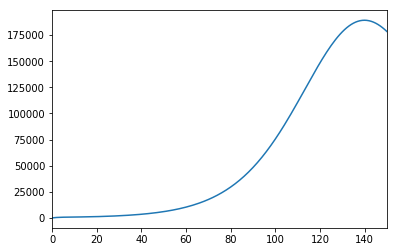

In [10]:
pd.Series(infectious_agents).plot()